# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

## Resumen

El algoritmo que se utiliza en esta aplicación es un filtro colaborativo, basado en los comentarios que los usuarios realizaron en las opiniones de Steam.
El algoritmo se basa en los comentarios de un usuario, con estos comentarios se genera una función de puntuación, que se utiliza en el filtro colaborativo para generar una lista de juegos basada en los gustos del usuario.
Este algoritmo realiza una elección de un juego en base a los gustos del usuario, y esto se realiza mediante el filtro colaborativo.

## Introducción

[**Steam**](https://store.steampowered.com/?l=spanish) es una plataforma de video juegos online que se conecta a través de internet, la cual nos permite realizar opiniones de los juegos, compartidas entre usuarios la plataforma.
Es una herramienta de juegos muy económica, y que ofrece una gran cantidad de opciones para los usuarios.

Una problemática que se nos presenta antes tan abundante y variada oferta de juegos, es la **difícil decisión de seleccionar un juego en particular.**
No siempre sabemos si un juego nos gusta o no, por lo tanto, si nos decidimos por un juego y luego de probarlo, nos damos cuenta de que no nos gusta, pasamos mucho tiempo sin poder disfrutar de otro juego.

**Por lo tanto, vimos la necesidad de entrenar a una IA para que nos sugiera un juego, y así poder realizar una buena elección.**

La elección de un juego en particular se ve influenciada por muchos factores, como por ejemplo, personalidad, gustos, etc.
Uno de los motores de este proyecto es el de crear un algoritmo que nos sugiera un juego, basado en preferencias dadas por un usuario.

El sistema debe poder decidir la elección de un juego, basado en los gustos del usuario, con esto se pretende que el sistema sea capaz de realizar una elección basada en los gustos de un usuario, y esto lo conseguimos mediante la aplicación de un filtro colaborativo.

El algoritmo utiliza el **filtro colaborativo**, basado en los comentarios que un gran números de usuarios realizó en las opiniones (reviews) de los juegos que jugó, para generar una puntuación. Esta puntuación se utiliza para realizar una elección de un juego basada en los gustos del usuario.
De esta manera, es posible que el sistema genere una lista de juegos, basada en los comentarios que los usuarios realizaron en las opiniones de Steam.

¿Que es el filtro colaborativo?

Es un filtro estadístico utilizado para generar predicciones, basado en el comportamiento de un número grande de usuarios.

¿Cómo trabaja el algoritmo?

Para trabajar el algoritmo se debe de generar una función de puntuación basada en la opinión de los usuarios, esta función se utiliza en el filtro colaborativo para generar una lista de juegos en base a la puntuación del usuario y a la que se le asigna una puntuación basada en su perfil.

#### Repositorio de Github
El proyecto se encuentro publicado en el siguiente [link de Github](https://github.com/jmquintana/data_science_sprint_3)

## Parta A - Exploración de Datos

### Importamos las librerías

In [1]:
# Importamos las librerías que vamos a necesitar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm.notebook import tqdm
import gzip
import re
import nltk
from sklearn.preprocessing import MinMaxScaler
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import RandomizedSearchCV

### Configuraciones

In [2]:
# Le doy formato a los gráficos
# sns.set_style("darkgrid")
sns.set_style("white")
plt.rc('font', size=10)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=16)
plt.rc('figure', titlesize=16)
plt.rc('axes', labelsize=14) 
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

In [3]:
#Seteamos para que no utilice notacion cientifica
pd.options.display.float_format = '{:.4f}'.format
#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# Instanciamos método para ver el progreso de las operaciones sobre sobre los dataframes
tqdm.pandas()
# Indicador de tiempo de ejecución
%load_ext autotime

In [107]:
# Las siguientes lineas permiten habilitar o deshabilitar ciertas operaciones
# procesamiento de datos para ahorrar tiempo de procesamiento.
READ_RAW = False
PROCESS_TEXT = True
POLARITY = True

### Carga y limpieza inicial de datos

In [41]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

#### Dataset de **Reviews**

In [230]:
# Atencion: la carga de los datos tarda alrededor de 5 minutos 30 segundos
if READ_RAW:
    contador = 0
    data_reviews = []
    # Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
    # abrira uno de cada tres, y asi.
    n = 10
    for l in tqdm(parse('steam_reviews.json.gz')):
        if contador%n == 0:
            data_reviews.append(l)
        else:
            pass
        contador += 1
    data_reviews = pd.DataFrame(data_reviews)

In [231]:
if READ_RAW:
    data_reviews.to_csv('data_reviews.csv', index_label='index')
else:
    data_reviews = pd.read_csv('data_reviews.csv')
    data_reviews.drop(columns='index', inplace=True)

In [232]:
# Previsualizamos las primeras 5 instancias del dataset
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1000,41.0000,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2000,1386.0000,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1000,1706.0000,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8000,2217.0000,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030368.0000,Product received for free,NaN
4,the_maker988,8.2000,18.0000,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396848.0000,NaN,NaN


In [233]:
# Previsualizamos las ultimas 5 instancias del dataset
data_reviews.tail()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
779302,Vidaar,783.5000,353.0000,252490,1,2013-12-11,Summary: Rust is a survival game created by Fa...,True,10217,NaN,NaN,NaN
779303,Nikolai Belinski,55.1000,204.0000,252490,1,2013-12-11,Coolest Game Eva,True,10218,NaN,NaN,NaN
779304,RancorZealot,203.5000,173.0000,252490,1,2013-12-11,Should you buy RUST? Uh... YES. The BEST Survi...,True,10219,76561197963920624.0000,NaN,NaN
779305,Jerry,139.8000,79.0000,252490,1,2013-12-11,Great game!,True,10220,76561198042664864.0000,NaN,NaN
779306,Helk,15375.0000,98.0000,252490,1,2013-12-11,I love this game!,True,10221,NaN,NaN,36.0000


In [234]:
# Reviso la informacion general del dataset
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779307 entries, 0 to 779306
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      779289 non-null  object 
 1   hours         776670 non-null  float64
 2   products      777741 non-null  float64
 3   product_id    779307 non-null  int64  
 4   page_order    779307 non-null  int64  
 5   date          779307 non-null  object 
 6   text          777468 non-null  object 
 7   early_access  779307 non-null  bool   
 8   page          779307 non-null  int64  
 9   user_id       317340 non-null  float64
 10  compensation  14588 non-null   object 
 11  found_funny   120164 non-null  float64
dtypes: bool(1), float64(4), int64(3), object(4)
memory usage: 66.1+ MB


In [235]:
# Vemos los missings
data_reviews.isna().sum()

username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

In [236]:
# Selecciono las columnas que me interesan y que creo que pueden ser de utilidad
columnas = ['username', 'hours', 'product_id', 'text','user_id']
data_reviews = data_reviews[columnas]
data_reviews.head()

,username,hours,product_id,text,user_id
0,Chaos Syren,0.1000,725280,This would not be acceptable as an entertainme...,NaN
1,Ariman1,13.2000,328100,Addictive RPG ! Works fine on linux though it ...,NaN
2,freakfantom,0.1000,725280,Прикольная стрелялка. Взял дешево на распродаже.,NaN
3,The_Cpt_FROGGY,7.8000,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,76561198003030368.0000
4,the_maker988,8.2000,35140,"This game was way to linear for me, and compar...",76561198353396848.0000


In [237]:
# Vemos los missings
data_reviews.isna().sum()

username          18
hours           2637
product_id         0
text            1839
user_id       461967
dtype: int64

In [238]:
# Para las instancias que no tienen 'user id' voy a generar uno sintetico
# Como la columna de 'user id' tiene muchos missings, voy a generar un id
# para cada 'username'
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_reviews['user_id'] = le.fit_transform(data_reviews.username)

# data_reviews1 = data_reviews[~data_reviews.user_id.isna()]
# data_reviews2 = data_reviews[data_reviews.user_id.isna()]
# data_reviews1['uid'] = data_reviews1['user_id']
# data_reviews2['uid'] = le.fit_transform(data_reviews2.username)
# data_reviews = pd.concat([data_reviews1, data_reviews2])
data_reviews.head()

,username,hours,product_id,text,user_id
0,Chaos Syren,0.1000,725280,This would not be acceptable as an entertainme...,62543
1,Ariman1,13.2000,328100,Addictive RPG ! Works fine on linux though it ...,26902
2,freakfantom,0.1000,725280,Прикольная стрелялка. Взял дешево на распродаже.,434602
3,The_Cpt_FROGGY,7.8000,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,347902
4,the_maker988,8.2000,35140,"This game was way to linear for me, and compar...",503848


In [239]:
# Chequeo que no tengo missings
data_reviews.isna().sum()

username        18
hours         2637
product_id       0
text          1839
user_id          0
dtype: int64

In [240]:
# Verifico los tipos de dato
data_reviews.dtypes

username       object
hours         float64
product_id      int64
text           object
user_id         int32
dtype: object

In [241]:
# Redefino el tipo de dato de 'user_id' a int64
data_reviews['product_id'] = data_reviews['product_id'].astype(dtype='int64')
data_reviews['user_id'] = data_reviews['user_id'].astype(dtype='int64')
data_reviews.dtypes

username       object
hours         float64
product_id      int64
text           object
user_id         int64
dtype: object

In [242]:
# Exploro los estadisticos del dataset
data_reviews.describe(include='object')

,username,text
count,779289,777468
unique,540338,718776
top,123,good game
freq,213,1206


In [243]:
# Exploro más estadisticos del dataset
data_reviews.describe()

,hours,product_id,user_id
count,776670.0000,779307.0000,779307.0000
mean,111.8438,251489.8221,263410.8997
std,390.1454,149975.3705,154077.9124
min,0.0000,10.0000,0.0000
25%,4.0000,203770.0000,130630.5000
50%,15.3000,252490.0000,260874.0000
75%,59.6000,346110.0000,391979.5000
max,28164.0000,773900.0000,540338.0000


#### Dataset de **Games**

In [244]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [245]:
# Previsualizo las primeras 5 instancias
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.4900,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.9900,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8300,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.9900,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.7900,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.9900,False,773570,NaN,NaN,NaN


In [246]:
# Revisamos si existen instancias duplicadas
data_games[data_games.duplicated(subset='id', keep=False)]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
74,NaN,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,14.9900,NaN,NaN,19.9900,False,NaN,NaN,NaN,NaN
13894,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",NaN,http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.9900,False,612880,Machine Games,Mostly Positive,86
14573,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",NaN,http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.9900,False,612880,Machine Games,Mostly Positive,86
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,NaN,"[Single-player, Steam Achievements, Steam Trad...",19.9900,False,NaN,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [247]:
# Como vemos que existen dos 'id' duplicados y dos NaN, procedemos a eliminarlos
print('Size antes de eliminar instancias', data_games.shape)
data_games.drop_duplicates(subset=['id'], inplace=True)
data_games.dropna(subset=['id'], inplace=True)
print('Size después de eliminar instancias', data_games.shape)

Size antes de eliminar instancias (32135, 16)
Size después de eliminar instancias (32132, 16)


In [248]:
# Previsualizo las ultimas 5 instancias
data_games.tail()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.4900,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.9900,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.2400,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.9900,False,733530,Sacada,NaN,NaN
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.3900,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.9900,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.9900,False,658870,"xropi,stev3ns",1 user reviews,NaN
32134,NaN,NaN,Maze Run VR,NaN,http://store.steampowered.com/app/681550/Maze_...,NaN,"[Early Access, Adventure, Indie, Action, Simul...",NaN,http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.9900,True,681550,NaN,Positive,NaN


In [249]:
# Reviso la informacion general del dataset
data_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32132 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24081 non-null  object 
 1   genres          28850 non-null  object 
 2   app_name        32131 non-null  object 
 3   title           30083 non-null  object 
 4   url             32132 non-null  object 
 5   release_date    30066 non-null  object 
 6   tags            31970 non-null  object 
 7   discount_price  224 non-null    float64
 8   reviews_url     32132 non-null  object 
 9   specs           31463 non-null  object 
 10  price           30755 non-null  object 
 11  early_access    32132 non-null  bool   
 12  id              32132 non-null  object 
 13  developer       28834 non-null  object 
 14  sentiment       24951 non-null  object 
 15  metascore       2675 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 4.0+ MB


In [250]:
# Vemos los missings
data_games.isna().sum()

publisher          8051
genres             3282
app_name              1
title              2049
url                   0
release_date       2066
tags                162
discount_price    31908
reviews_url           0
specs               669
price              1377
early_access          0
id                    0
developer          3298
sentiment          7181
metascore         29457
dtype: int64

In [251]:
# Selecciono las columnas que me interesan
# Descarto la columna 'title' ya que tienen muchos missings y la columna 'app_name' tiene los nombres de los juegos
columnas = ['publisher', 'genres', 'app_name', 'tags', 'specs', 'price', 'id', 'developer', 'sentiment']
data_games = data_games[columnas]
data_games.head()

,publisher,genres,app_name,tags,specs,price,id,developer,sentiment
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.9900,761140,Kotoshiro,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,643980,Secret Level SRL,Mostly Positive
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",Free to Play,670290,Poolians.com,Mostly Positive
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.9900,767400,彼岸领域,NaN
4,NaN,NaN,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.9900,773570,NaN,NaN


In [252]:
# Vemos los missings
data_games.isna().sum()

publisher    8051
genres       3282
app_name        1
tags          162
specs         669
price        1377
id              0
developer    3298
sentiment    7181
dtype: int64

In [253]:
# Descarto los missings de 'app_name'
data_games.dropna(axis=0, subset=['app_name'], inplace=True)

In [254]:
# Observamos los tipos de dato
data_games.dtypes

publisher    object
genres       object
app_name     object
tags         object
specs        object
price        object
id           object
developer    object
sentiment    object
dtype: object

In [255]:
# Cambio el tipo de dato de la columna 'id' para que coincida con la del dataframe 'data_reviews' 
data_games['id'] = data_games['id'].astype('int64')

In [256]:
# Chequeo los data types
data_games.dtypes

publisher    object
genres       object
app_name     object
tags         object
specs        object
price        object
id            int64
developer    object
sentiment    object
dtype: object

In [257]:
# Agregamos el nombre del juego al dataframe de reviews
data_reviews = pd.merge(data_reviews, data_games[['id', 'app_name']], how='left', left_on='product_id', right_on='id')
data_reviews.drop(['id'], axis=1, inplace=True)
data_reviews.shape

(779307, 6)

In [258]:
data_reviews.head()

,username,hours,product_id,text,user_id,app_name
0,Chaos Syren,0.1000,725280,This would not be acceptable as an entertainme...,62543,Psi Project
1,Ariman1,13.2000,328100,Addictive RPG ! Works fine on linux though it ...,26902,Gunspell - Steam Edition
2,freakfantom,0.1000,725280,Прикольная стрелялка. Взял дешево на распродаже.,434602,Psi Project
3,The_Cpt_FROGGY,7.8000,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,347902,Somewhere on Zibylon
4,the_maker988,8.2000,35140,"This game was way to linear for me, and compar...",503848,Batman: Arkham Asylum Game of the Year Edition


### Procesamiento de texto

A continuacion vamos a procesar el campo 'text' (que contiene los comentarios de las reviews) para inferir un 'rating' y poder tener una medida de la preferencia del usuario respecto del juego sobre el cual realizó la opinión.

In [259]:
# Trabajaremos sobre una copia del dataset de reviews
df_reviews = data_reviews.copy()

In [260]:
df_reviews.shape

(779307, 6)

#### Limpieza del campo 'text'

In [261]:
nltk.download('stopwords')
# Instanciamos el tokenizer
tokenizer=RegexpTokenizer("\w+")

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
stemmer = PorterStemmer()

# Instanciamos el Lemmatizer
lemmatizer = WordNetLemmatizer()

# Traemos las stopwords
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [262]:
# Creo funcion para identificar el rol de cada palabra en el texto del comentario
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [263]:
# Creamos método para aplicar la Normalizacion y luega el Stemming a cada instancia
def processText(text):
    
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    text = re.sub("[^a-zA-Z]"," ",str(text))
    
    # Pasamos todo a minúsculas
#     text = text.lower()
    
    # Tokenizamos para separar las palabras del titular
    text = tokenizer.tokenize(text)
    
    # Eliminamos las palabras de menos de 4 letras
    text = [palabra for palabra in text if len(palabra) >= 3]
    
    # Sacamos las Stopwords
    text = [p for p in text if not p in stopwords]
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
#     text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    # Aplicamos la funcion para buscar la raiz de las palabras
#     text = [stemmer.stem(t) for t in text]
    
    # Por ultimo volvemos a unir el titular
    text = " ".join(text)
    
    return text

In [264]:
# Aplicamos la transformación
if PROCESS_TEXT:
    df_reviews['cleaned_text'] = df_reviews['text'].progress_apply(processText)
    df_reviews.to_csv('df_reviews.csv', index_label='index')
else:
    df_reviews = pd.read_csv('df_reviews.csv')
    df_reviews.drop(columns='index', inplace=True)

  0%|          | 0/779307 [00:00<?, ?it/s]

In [265]:
# Mostramos el dataset limpio
rand_list = np.random.choice(df_reviews.index, size=5)
df_reviews.loc[rand_list]

,username,hours,product_id,text,user_id,app_name,cleaned_text
477594,Mr. Dump Ling,11.4000,301640,"For those claiming too scray, i say just enoug...",228755,Zombie Army Trilogy,For claiming scray say enough For claiming rep...
684957,Merim,23.8000,225300,"This is actually harder than Tomb Raider I, es...",219592,Tomb Raider II,This actually harder Tomb Raider especially pu...
564081,vanillaTHUNDAR,11.3000,243120,Why the hell did we start using guns?,510324,Betrayer,Why hell start using guns
533429,NeKryXe,658.6000,364470,the perfect coffee break for an Elder Scrolls ...,238082,The Elder Scrolls®: Legends™,perfect coffee break Elder Scrolls Online mara...
268708,FrenchyToastGun,10.4000,312150,The game is overall ok but one thing that is m...,124613,Wild Warfare,The game overall one thing making mad whilst o...


In [266]:
df_reviews.isna().sum()

username          18
hours           2637
product_id         0
text            1839
user_id            0
app_name           0
cleaned_text       0
dtype: int64

In [267]:
# df_reviews.cleaned_text = df_reviews.cleaned_text.str.strip()
# df_reviews.cleaned_text.replace('', np.nan, inplace=True)

In [268]:
df_reviews.isna().sum()

username          18
hours           2637
product_id         0
text            1839
user_id            0
app_name           0
cleaned_text       0
dtype: int64

In [269]:
# df_reviews.dropna(subset=['cleaned_text'], inplace=True)

#### Análisis de polaridad de los comentarios

In [270]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [271]:
sia = SentimentIntensityAnalyzer()
def polaridad(text):
    return sia.polarity_scores(text)['compound']

In [272]:
df_reviews.isna().sum()

username          18
hours           2637
product_id         0
text            1839
user_id            0
app_name           0
cleaned_text       0
dtype: int64

In [273]:
if POLARITY:
    df_reviews['polarity'] = df_reviews['cleaned_text'].progress_apply(polaridad)
    df_reviews.to_csv('df_reviews.csv', index_label='index')
else:
    df_reviews = pd.read_csv('df_reviews.csv')
    df_reviews.drop(columns='index', inplace=True)

  0%|          | 0/779307 [00:00<?, ?it/s]

In [274]:
# Creamos una columns de Rating entre 0 y 5, escalando la columna 'polarity'
column=df_reviews[['polarity']]
scaler = MinMaxScaler(feature_range=(0,5))
df_reviews['rating'] = scaler.fit_transform(column)
df_reviews.loc[rand_list]

,username,hours,product_id,text,user_id,app_name,cleaned_text,polarity,rating
477594,Mr. Dump Ling,11.4000,301640,"For those claiming too scray, i say just enoug...",228755,Zombie Army Trilogy,For claiming scray say enough For claiming rep...,-0.5719,1.0703
684957,Merim,23.8000,225300,"This is actually harder than Tomb Raider I, es...",219592,Tomb Raider II,This actually harder Tomb Raider especially pu...,0.8066,4.5165
564081,vanillaTHUNDAR,11.3000,243120,Why the hell did we start using guns?,510324,Betrayer,Why hell start using guns,-0.6808,0.7980
533429,NeKryXe,658.6000,364470,the perfect coffee break for an Elder Scrolls ...,238082,The Elder Scrolls®: Legends™,perfect coffee break Elder Scrolls Online mara...,0.5719,3.9297
268708,FrenchyToastGun,10.4000,312150,The game is overall ok but one thing that is m...,124613,Wild Warfare,The game overall one thing making mad whilst o...,-0.4939,1.2652


In [275]:
# Mostramos el dataset limpio
df_reviews.loc[rand_list]

,username,hours,product_id,text,user_id,app_name,cleaned_text,polarity,rating
477594,Mr. Dump Ling,11.4000,301640,"For those claiming too scray, i say just enoug...",228755,Zombie Army Trilogy,For claiming scray say enough For claiming rep...,-0.5719,1.0703
684957,Merim,23.8000,225300,"This is actually harder than Tomb Raider I, es...",219592,Tomb Raider II,This actually harder Tomb Raider especially pu...,0.8066,4.5165
564081,vanillaTHUNDAR,11.3000,243120,Why the hell did we start using guns?,510324,Betrayer,Why hell start using guns,-0.6808,0.7980
533429,NeKryXe,658.6000,364470,the perfect coffee break for an Elder Scrolls ...,238082,The Elder Scrolls®: Legends™,perfect coffee break Elder Scrolls Online mara...,0.5719,3.9297
268708,FrenchyToastGun,10.4000,312150,The game is overall ok but one thing that is m...,124613,Wild Warfare,The game overall one thing making mad whilst o...,-0.4939,1.2652


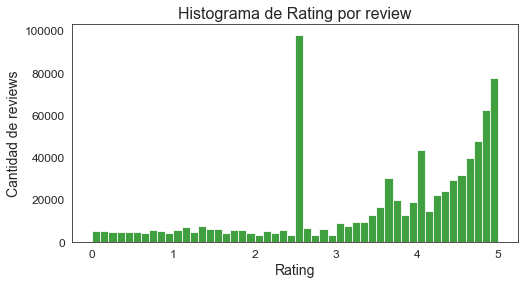

In [277]:
# Finalmente observamos la distribucion
plt.figure(figsize=(8,4))
sns.histplot(data=df_reviews, x='rating', color='green', label='rating', bins=50)
plt.title('Histograma de Rating por review')
# plt.legend()
plt.ylabel('Cantidad de reviews')
plt.xlabel('Rating')
plt.xticks(rotation=0)
plt.show()

En el histograma podemos observar que la clase 'rating' (que será el target de nuestro modelo) está muy desbalanceada. Se puede ver que existen muchas instancias con un valor de rating de 2.5 (ni bueno, ni malo) que no da información valiosa para el filtro colaborativo. En principio, utilizaremos los datos como están y evaluaremos la permormance del modelo. Si fuera necesario, luego veremos qué podemos mejorar.

### Análisis del Dataset

Antes de continuar, vamos a responder algunas preguntas sobre el dataset para entenderlo mejor

#### 1. ¿Cuáles son los 10 usuarios con más reviews realizadas?

In [278]:
preg_1 = df_reviews.groupby('user_id').agg({'username':'first', 'text':'count', 'rating':'mean'})
preg_1.sort_values('text', ascending=False).reset_index().head(10)

,user_id,username,text,rating
0,5463,123,213,3.3397
1,19181,Alex,189,3.6832
2,65614,Chris,154,3.6310
3,240929,Nick,143,3.6029
4,215286,Matt,137,3.6927
5,352718,Tom,129,3.5946
6,171256,John,127,3.4931
7,164226,Jack,123,3.4235
8,82216,Dan,119,3.3844
9,293526,Saint Aaron,114,3.5551


#### 2. ¿Cuáles son los 10 juegos con mejor rating?

In [303]:
preg_2 = df_reviews.groupby('product_id').agg({'app_name':'first', 'text':'count', 'rating':'mean'})
preg_2.columns = ['game', 'reviews', 'rating_mean']
preg_2 = preg_2.sort_values('rating_mean', ascending=False).reset_index()
preg_2.head(10)

,product_id,game,reviews,rating_mean
0,430930,Z. Year One,1,4.9990
1,486810,House of Snark 6-in-1 Bundle,1,4.9985
2,410370,Huenison,1,4.9983
3,551520,Last Days of Spring 2,1,4.9977
4,505070,Secrets of Me,1,4.9975
5,619350,Sandra and Woo in the Cursed Adventure,1,4.9973
6,620900,Witchinour,1,4.9968
7,629860,Spelunker Party!,1,4.9968
8,713050,Vampires!,1,4.9965
9,553780,ARK BOX Unlimited,1,4.9965


En la respuesta anterior podemos ver que los 10 juegos mejor calificados tienen sólo 1 review.
Para obtener una lista más representativa, vamos a filtrar aquéllos juegos que tengan al menos 10 reviews.

#### 3. ¿Cuáles son los 10 juegos (con al menos 10 reviews) con mejor rating?

In [304]:
preg_3 = preg_2[preg_2.reviews >= 10]
preg_3.sort_values('rating_mean', ascending=False).reset_index().head(10)

,index,product_id,game,reviews,rating_mean
0,595,337720,The Sea Will Claim Everything,10,4.9085
1,931,380810,Herald: An Interactive Period Drama - Book I & II,11,4.8448
2,1081,449250,A Little Lily Princess,12,4.8144
3,1172,440540,Ara Fell,24,4.7955
4,1189,331870,AER Memories of Old,15,4.7901
5,1252,302130,Brink of Consciousness: Dorian Gray Syndrome C...,11,4.7780
6,1259,306200,The Happy Hereafter,13,4.7752
7,1299,264520,Moebius: Empire Rising,14,4.7694
8,1321,544180,Orbox C,11,4.7643
9,1388,463980,Solitairica,12,4.7519


In [292]:
df_ratings = df_reviews.groupby('product_id').agg({'rating':['count','mean']}).reset_index()
df_ratings.columns = ['product_id', 'count', 'rating_mean']
df_ratings.sort_values(by='rating_mean', ascending=False, inplace=True)
df_ratings.reset_index(inplace=True, drop=True)
df_ratings

,product_id,count,rating_mean
0,430930,1,4.9990
1,486810,1,4.9985
2,410370,1,4.9983
3,551520,1,4.9977
4,505070,1,4.9975
...,...,...,...
12660,446250,1,0.0112
12661,661590,1,0.0107
12662,607700,1,0.0107
12663,675720,1,0.0055


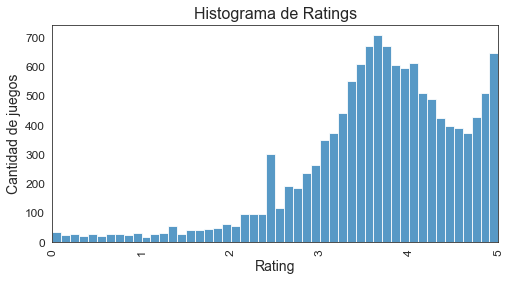

In [332]:
min_reviews = 1
df_filter = preg_2[preg_2['reviews'] >= min_reviews]

plt.figure(figsize=(8,4))
plt.title('Histograma de Ratings')
sns.histplot(data=df_filter, x='rating_mean', bins=50)
plt.ylabel('Cantidad de juegos')
plt.xlabel('Rating')
plt.xticks(rotation=90)
plt.xlim(0,5)
plt.show()

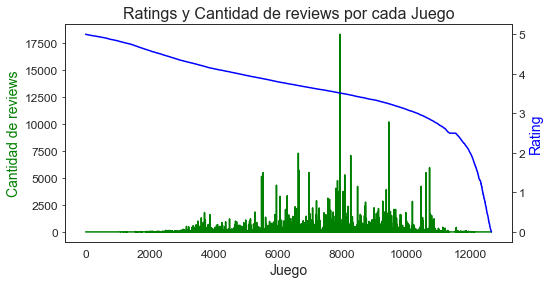

In [355]:
x = df_filter.index
y1 = df_filter['reviews']
y2 = df_filter['rating_mean']

fig, ax1 = plt.subplots(figsize=(8,4))
plt.title('Ratings y Cantidad de reviews por cada Juego')

ax2 = ax1.twinx()
# ax1.plot(x, y1, 'g-')
# ax2.plot(x, y2, 'b-')

sns.lineplot(ax=ax1, x=x, y=y1, color='green')
sns.lineplot(ax=ax2, x=x, y=y2, color='blue')

ax1.set_xlabel('Juego')
ax1.set_ylabel('Cantidad de reviews', color='g')
ax2.set_ylabel('Rating', color='b')

plt.show()

#### 4. ¿Existen comentarios repetidos? ¿Cuántos y cuáles?

In [364]:
preg_4 = df_reviews.groupby('cleaned_text').agg({'cleaned_text':'count', 'rating':'mean'})
preg_4.columns = ['cantidad', 'rating']
preg_4 = preg_4.sort_values('cantidad', ascending=False).reset_index()
preg_4.head(10)

,cleaned_text,cantidad,rating
0,,13595,2.5000
1,good,2594,3.6010
2,good game,2146,3.6010
3,nan,1840,2.5000
4,Great game,1408,4.0622
5,fun,1054,3.7765
6,Good game,1035,3.6010
7,great game,952,4.0622
8,nice game,782,3.5538
9,nice,744,3.5538


Podemos ver que exiten muchos comentarios vacíos que terminan resultando en un rating igual a 2.5 (neutro) y que no aportará información útil al modelo. Es otro punto a tener en cuenta a la hora de intentar mejorar los datos.

## Parte B - Modelo de Machine Learning

### Filtro Colaborativo a partir de descomposición UV

#### Dataset y Train/Test Split

In [374]:
reader = Reader()
data = Dataset.load_from_df(df_reviews[['user_id', 'product_id', 'rating']], reader)
trainset, testset = train_test_split(data, random_state=42, test_size=.3)

#### Entrenamiento

In [375]:
from surprise import SVD, SVDpp, SlopeOne, BaselineOnly
algo = SVD()

In [376]:
algo.fit(trainset)

In [377]:
predictions = algo.test(testset)

In [378]:
accuracy.mae(predictions)
accuracy.rmse(predictions)

MAE:  1.0397
RMSE: 1.2719


1.2718742434930623

#### Optimizacion del Modelo

##### Optimizacion con Random Search

In [379]:
param_grid = {'n_factors': [5,50,100,150],
              'n_epochs': [5,10,20],
              'lr_all': [0.001,0.002,0.005],
              'reg_all': [0.002,0.02,0.2]}

gs = RandomizedSearchCV(SVD,
                  param_grid,
                  measures=['rmse'],
                  cv=3,
                  n_jobs = -1,
                  joblib_verbose =10)

gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  2.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  3.0min remaining:   54.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  3.2min remaining:   21.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.2min finished


In [380]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.2677895521509377
{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.2}


### Optmizacion del Rating

Una forma de mejorar la performance del modelo seria mejorar la calidad de los datos.
Como ya pudimos ver, nuestra variable target, el Rating, podría mejorarse.
Debido a que contamos con la informacion del tiempo dedicado a cada juego por parte de cada jugador, podriamos inferir que cuanto mas tiempo le ha dedicado el usuario al juego en cuestion, más interés y por ende mayor preferencia por el juego representa.
Por todo esto, podríamos cuantificar las horas dedicadas a jugar dentro del rating: a mayor cantidad de tiempo, se le agregará un plus al rating calculado en base al comentario, y cuanto menos tiempo, se le restará.

In [381]:
df_reviews.head()

,username,hours,product_id,text,user_id,app_name,cleaned_text,polarity,rating
0,Chaos Syren,0.1000,725280,This would not be acceptable as an entertainme...,62543,Psi Project,This would acceptable entertainment even back ...,0.7506,4.3765
1,Ariman1,13.2000,328100,Addictive RPG ! Works fine on linux though it ...,26902,Gunspell - Steam Edition,Addictive RPG Works fine linux though minor bu...,0.2023,3.0057
2,freakfantom,0.1000,725280,Прикольная стрелялка. Взял дешево на распродаже.,434602,Psi Project,,0.0000,2.5000
3,The_Cpt_FROGGY,7.8000,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,347902,Somewhere on Zibylon,Somewhere Zibylon Zibylon command centre read ...,0.9729,4.9322
4,the_maker988,8.2000,35140,"This game was way to linear for me, and compar...",503848,Batman: Arkham Asylum Game of the Year Edition,This game way linear compared others good For ...,0.5859,3.9647


Debido a que los juegos no tienen una duración en común, es decir, existen juegos que duran más que otros (e incluso hay juegos que no tienen una duración fija y se puede jugar indefinidamente), deberíamos normalizar la duración máxima de cada juego en particular.
Para ello, vamos a calcular, de las reviews de los usuarios, la cantidad de horas mínima y máxima jugada a cada juego. Luego vamos a normalizar las horas jugadas por el usuario en función de las horas máxima y mínima global de cada juego en particular. Así crearemos un variable continua entre -1 y 1: -1 significa que usuario jugó muy poco y 1 que jugó el máximo de horas definido para ese juego.

In [390]:
# Creamos un dataframe con las cantidad de horas minima y maxima dedicada a cada juego.
df_hours = df_reviews.groupby('product_id').hours.agg(minimo=np.min, maximo=np.max).sort_values(by='maximo', ascending=False)
df_hours.reset_index()

,product_id,minimo,maximo
0,224600,0.2000,28164.0000
1,8500,0.1000,23184.2000
2,320,0.1000,20573.3000
3,363970,0.0000,20018.9000
4,24010,0.1000,19205.2000
...,...,...,...
12660,598390,NaN,NaN
12661,604090,NaN,NaN
12662,625660,NaN,NaN
12663,645180,NaN,NaN


In [391]:
# Redefinimos el mínimo en cero
df_hours.minimo = np.zeros(df_hours.shape[0])

In [392]:
# Vemos que hay missings. Vamos a ver cuantos hay.
df_hours.isna().sum()

minimo     0
maximo    45
dtype: int64

In [393]:
# Rellenamos los mínimos con 0 y los máximos con 1
df_hours.minimo.fillna(0, inplace=True)
df_hours.maximo.fillna(1, inplace=True)
df_hours

,minimo,maximo
product_id,,
224600,0.0000,28164.0000
8500,0.0000,23184.2000
320,0.0000,20573.3000
363970,0.0000,20018.9000
24010,0.0000,19205.2000
...,...,...
598390,0.0000,1.0000
604090,0.0000,1.0000
625660,0.0000,1.0000


In [394]:
df_hours.reset_index(inplace=True)

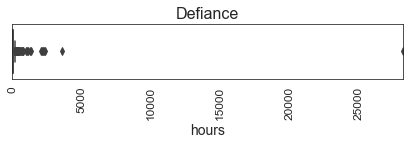

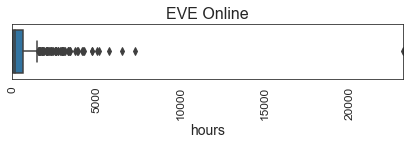

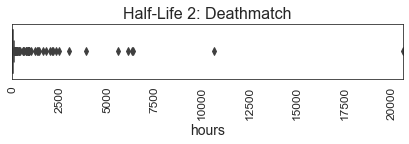

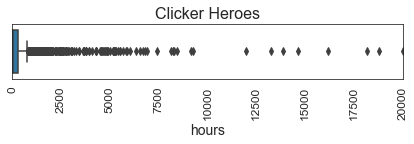

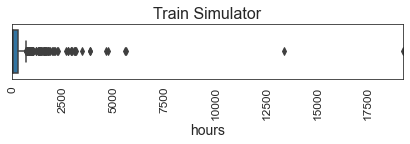

In [395]:
# Exploremos las densidaes de distribucion de horas de los juegos con mas horas
for product_id in df_hours[:5].product_id:    
    plt.figure(figsize=(7,1))
    sns.boxplot(data=df_reviews[df_reviews.product_id==product_id], x='hours')
    plt.title(data_games[data_games.id == product_id].app_name.values[0])
    plt.xlabel('hours')
    plt.xlim(0,df_hours[df_hours.product_id==product_id].maximo.values[0])
    plt.xticks(rotation=90)
    plt.show()

In [396]:
# Como vemos que existen muchos valores outliers,
# vamos a crear una funcion para topear el maximo
# en el percentil 90
def topMax(index):
    top = df_reviews[df_reviews.product_id==index].quantile(.90).hours
    if np.isnan(top):
        top = 1
    return top

In [397]:
df_hours['maximo'] = df_hours.product_id.progress_apply(topMax)
df_hours.sort_values(by='maximo', ascending=False)

  0%|          | 0/12665 [00:00<?, ?it/s]

,product_id,minimo,maximo
47,385020,0.0000,7290.4400
21,466170,0.0000,5535.8900
98,408030,0.0000,4217.8400
146,340990,0.0000,4038.6200
130,454550,0.0000,3525.0500
...,...,...,...
12615,8690,0.0000,0.0000
12616,44620,0.0000,0.0000
12617,355950,0.0000,0.0000
12618,331181,0.0000,0.0000


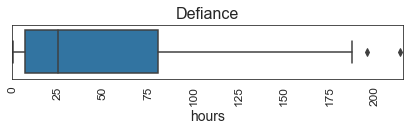

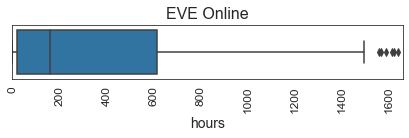

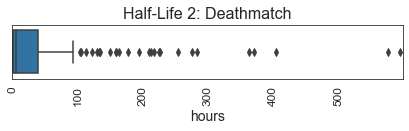

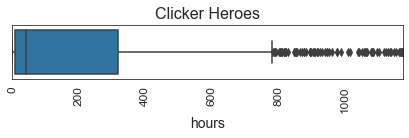

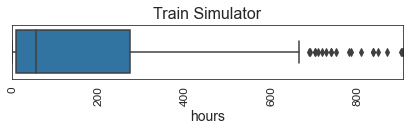

In [398]:
# Volvemos a chequear las distribuciones de los ratings por juego
for product_id in df_hours[:5].product_id:    
    plt.figure(figsize=(7,1))
    sns.boxplot(data=df_reviews[df_reviews.product_id==product_id], x='hours')
    plt.title(data_games[data_games.id == product_id].app_name.values[0])
    plt.xlim(0,df_hours[df_hours.product_id==product_id].maximo.values[0])
    plt.xticks(rotation=90)
    plt.show()

In [399]:
# Agrego las columnas de 'minimo' y 'maximo' al dataframe de las reviews
try:
    df_reviews.drop(['minimo', 'maximo'], axis=1, inplace=True)
except:
    df_reviews.head()
df_reviews = pd.merge(df_reviews, df_hours, how='left', left_on='product_id', right_on='product_id')
df_reviews.shape

(779307, 11)

In [402]:
# Genero una nueva columna normalizando la columna 'hours' entre -1 y 1
# Dicha columna, posteriormente se utilizará para sumar a la columna 'rating'
# De modo de considerar en la valoración, la cantidad de tiempo relativa que
# cada usuario dedico a jugar ese juego en particular. Así, si jugó muchas horas
# el 'hr_factor' estará más cerca de 1 y si jugo muy poco, estará más cerca de -1

df_reviews['hr_factor'] = np.minimum((df_reviews['hours']-df_reviews['minimo'])/(df_reviews['maximo']-df_reviews['minimo'])*2-1, 1)
df_reviews['hr_factor'] = df_reviews['hr_factor'].fillna(0)
df_reviews[['username', 'product_id', 'text', 'user_id', 'cleaned_text', 'polarity', 'rating', 'hours', 'minimo', 'maximo', 'hr_factor']]

,username,product_id,text,user_id,cleaned_text,polarity,rating,hours,minimo,maximo,hr_factor
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,62543,This would acceptable entertainment even back ...,0.7506,4.3765,0.1000,0.0000,0.1000,1.0000
1,Ariman1,328100,Addictive RPG ! Works fine on linux though it ...,26902,Addictive RPG Works fine linux though minor bu...,0.2023,3.0057,13.2000,0.0000,7.5600,1.0000
2,freakfantom,725280,Прикольная стрелялка. Взял дешево на распродаже.,434602,,0.0000,2.5000,0.1000,0.0000,0.1000,1.0000
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,347902,Somewhere Zibylon Zibylon command centre read ...,0.9729,4.9322,7.8000,0.0000,26.6800,-0.4153
4,the_maker988,35140,"This game was way to linear for me, and compar...",503848,This game way linear compared others good For ...,0.5859,3.9647,8.2000,0.0000,39.0000,-0.5795
...,...,...,...,...,...,...,...,...,...,...,...
779302,Vidaar,252490,Summary: Rust is a survival game created by Fa...,366849,Summary Rust survival game created Facepunch S...,-0.9905,0.0237,783.5000,0.0000,1177.4000,0.3309
779303,Nikolai Belinski,252490,Coolest Game Eva,242193,Coolest Game Eva,0.0000,2.5000,55.1000,0.0000,1177.4000,-0.9064
779304,RancorZealot,252490,Should you buy RUST? Uh... YES. The BEST Survi...,276240,Should buy RUST YES The BEST Survival Sandbox ...,0.9546,4.8865,203.5000,0.0000,1177.4000,-0.6543
779305,Jerry,252490,Great game!,168748,Great game,0.6249,4.0623,139.8000,0.0000,1177.4000,-0.7625


In [403]:
# Verificamos que 'hr_factor' esté entre -1 y 1
df_reviews.describe()

,hours,product_id,user_id,polarity,rating,minimo,maximo,hr_factor
count,776670.0000,779307.0000,779307.0000,779307.0000,779307.0000,779307.0000,779307.0000,779307.0000
mean,111.8438,251489.8221,263410.8997,0.4263,3.5658,0.0000,272.5729,-0.2759
std,390.1454,149975.3705,154077.9124,0.5231,1.3077,0.0000,443.5505,0.6565
min,0.0000,10.0000,0.0000,-1.0000,0.0000,0.0000,0.0000,-1.0000
25%,4.0000,203770.0000,130630.5000,0.0000,2.5000,0.0000,25.2500,-0.8406
50%,15.3000,252490.0000,260874.0000,0.6124,4.0310,0.0000,77.0000,-0.4747
75%,59.6000,346110.0000,391979.5000,0.8720,4.6800,0.0000,320.6600,0.1291
max,28164.0000,773900.0000,540338.0000,1.0000,5.0000,0.0000,7290.4400,1.0000


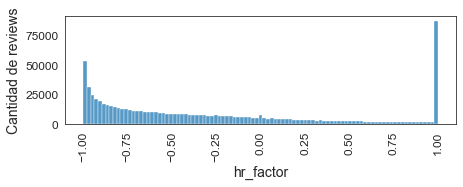

In [404]:
# Veamos la distribución de la variable
plt.figure(figsize=(7,2))
sns.histplot(data=df_reviews, x='hr_factor')
plt.ylabel('Cantidad de reviews')
plt.xlabel('hr_factor')
plt.xticks(rotation=90)
plt.show()

In [405]:
# ratings = []
# for n in tqdm(np.arange(df_reviews.shape[0])):
#     if df_reviews.iloc[n].polarity == 0:
#         rating = df_reviews.iloc[n].polarity + df_reviews.iloc[n].hr_factor
#     else:
#         rating = df_reviews.iloc[n].polarity
#     ratings.append(rating)

# df_reviews['hr_rating'] = ratings

In [119]:
# df_reviews['hr_rating'] = df_reviews['rating'] + df_reviews['hr_factor']

In [406]:
df_reviews['hr_rating'] = df_reviews['polarity'] + df_reviews['hr_factor']

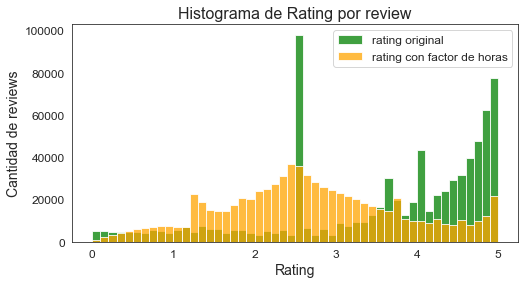

In [408]:
# Creamos la columna 'hr_rating' como la suma del 'rating' y 'hr_factor' 

# Y normalizamos entre 0 y 5
df_reviews['hr_rating'] = scaler.fit_transform(df_reviews[['hr_rating']])

# Finalmente observamos la distribucion
plt.figure(figsize=(8,4))
sns.histplot(data=df_reviews, x='rating', color='green', label='rating original', bins=50)
sns.histplot(data=df_reviews, x='hr_rating', color='orange', label='rating con factor de horas', bins=50)
plt.title('Histograma de Rating por review')
plt.legend()
plt.ylabel('Cantidad de reviews')
plt.xlabel('Rating')
plt.xticks(rotation=0)
plt.show()

Como podemos observar, la nueva variable Rating está mucho más balanceada que la original.

In [409]:
# Recalculamos el 'rating' promedio por juego 
df_ratings = df_reviews.groupby('product_id').agg({'rating':['count','mean'], 'hr_rating':['mean']}).reset_index()
df_ratings.columns = ['product_id', 'count', 'rating_mean', 'hr_rating_mean']
df_ratings.sort_values(by='hr_rating_mean', ascending=False, inplace=True)
df_ratings.reset_index(inplace=True, drop=True)

df_ratings

,product_id,count,rating_mean,hr_rating_mean
0,430930,1,4.9990,4.9995
1,486810,1,4.9985,4.9992
2,410370,1,4.9983,4.9991
3,551520,1,4.9977,4.9989
4,505070,1,4.9975,4.9987
...,...,...,...,...
12660,515690,4,1.3934,1.4120
12661,426560,7,2.0102,1.3931
12662,411310,3,0.6216,1.3467
12663,537090,3,0.5393,1.2821


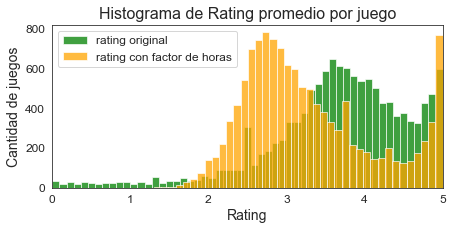

In [410]:
# Ahora vamos a graficar la comparacion entre las distribuciones
# de 'ratings' y 'hr_ratings'
df_filter = df_ratings[df_ratings['count'] >= 1]

plt.figure(figsize=(7,3))
sns.histplot(data=df_filter, x='rating_mean', color='green', label='rating original')
sns.histplot(data=df_filter, x='hr_rating_mean', color='orange', label='rating con factor de horas')
plt.title('Histograma de Rating promedio por juego')
plt.legend()
plt.ylabel('Cantidad de juegos')
plt.xlabel('Rating')
plt.xlim(0,5)
plt.xticks(rotation=0)
plt.show()

#### Dataset y Train/Test Split

In [416]:
df_filter_reviews = df_reviews[df_reviews.product_id.isin(df_filter.product_id)]
df_filter_reviews.shape

(779307, 13)

In [417]:
reader = Reader()
data = Dataset.load_from_df(df_reviews[['user_id', 'product_id', 'hr_rating']], reader)
# data = Dataset.load_from_df(df_filter_reviews[['user_id', 'product_id', 'random']], reader)
trainset, testset = train_test_split(data, random_state=42, test_size=.3)

#### Entrenamiento

In [418]:
from surprise import SVD, SVDpp, SlopeOne, BaselineOnly
algo = SVD()

In [419]:
algo.fit(trainset)

In [420]:
predictions = algo.test(testset)

In [421]:
accuracy.mae(predictions)
accuracy.rmse(predictions)

MAE:  0.8391
RMSE: 1.0693


1.069326601354949

##### Optimizacion con Grid Search

#### Dataset y Train/Test Split

In [422]:
reader = Reader()
data = Dataset.load_from_df(df_reviews[['user_id', 'product_id', 'hr_rating']], reader)
trainset, testset = train_test_split(data, random_state=42, test_size=.2)

In [423]:
param_grid = {'n_factors': [5,50,100,150],
              'n_epochs': [5,10,20],
              'lr_all': [0.001,0.002,0.005],
              'reg_all': [0.002,0.02,0.2]}

gs = RandomizedSearchCV(SVD,
                  param_grid,
                  measures=['rmse'],
                  cv=3,
                  n_jobs = -1,
                  joblib_verbose =10)

gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  3.0min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  3.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  4.2min remaining:   27.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.4min finished


In [424]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0680533684897389
{'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}
